In [16]:
# 📘 1. 라이브러리 불러오기
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 나눔고딕 폰트 경로 불러오기
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)


# 기본 폰트로 설정
plt.rcParams['font.family'] = fontprop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 📁 2. 전처리 완료된 CCTV 데이터 불러오기
df = pd.read_csv("../../data/processed_cctv.csv", encoding="cp949")

# ✅ 데이터 확인
print("✅ 데이터 로드 완료. 행 수:", len(df))
df.head()

✅ 데이터 로드 완료. 행 수: 4091


,자치구,안심 주소,위도,경도,CCTV 수량,수정 일시,시설유형,구역코드,세부번호,cluster
0,광진구,공원-광장-045-01,37.5460,127.1039,1,2022-12-01,공원-광장,45.0,01,0
1,광진구,공원-광장-045-02,37.5460,127.1039,1,2022-12-01,공원-광장,45.0,02,0
2,광진구,공원-광장-045-03,37.5460,127.1039,1,2022-12-01,공원-광장,45.0,03,0
3,광진구,공원-광장-045-비상벨,37.5460,127.1039,1,2022-12-01,공원-광장,45.0,비상벨,0
4,광진구,공원-광장-046-01,37.5482,127.1006,1,2022-12-01,공원-광장,46.0,01,0


📌 구역별 CCTV 수량 요약:
      구역코드  CCTV 수량
8      9.0       17
7      8.0       16
5      6.0       13
3      4.0       13
4      5.0       13
..     ...      ...
33    36.0        1
29    32.0        1
47    56.0        1
23    25.0        1
133  328.0        1

[221 rows x 2 columns]


/tmp/ipykernel_157521/10705002.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_grouped, x='구역코드', y='CCTV 수량', palette='Blues_d')


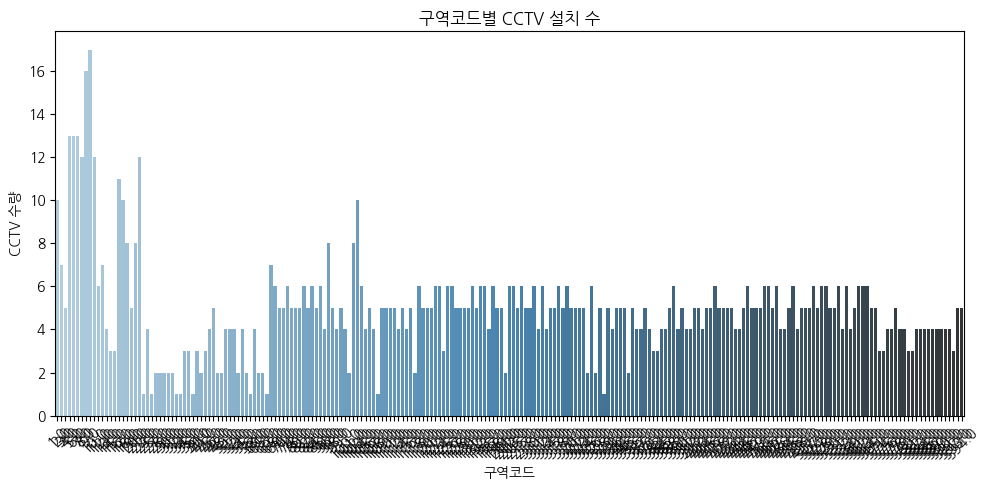

In [17]:
df_grouped = df.groupby('구역코드')['CCTV 수량'].sum().reset_index().sort_values(by='CCTV 수량', ascending=False)
print("📌 구역별 CCTV 수량 요약:")
print(df_grouped)

# 시각화 (막대그래프)
plt.figure(figsize=(10, 5))
sns.barplot(data=df_grouped, x='구역코드', y='CCTV 수량', palette='Blues_d')
plt.title("구역코드별 CCTV 설치 수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

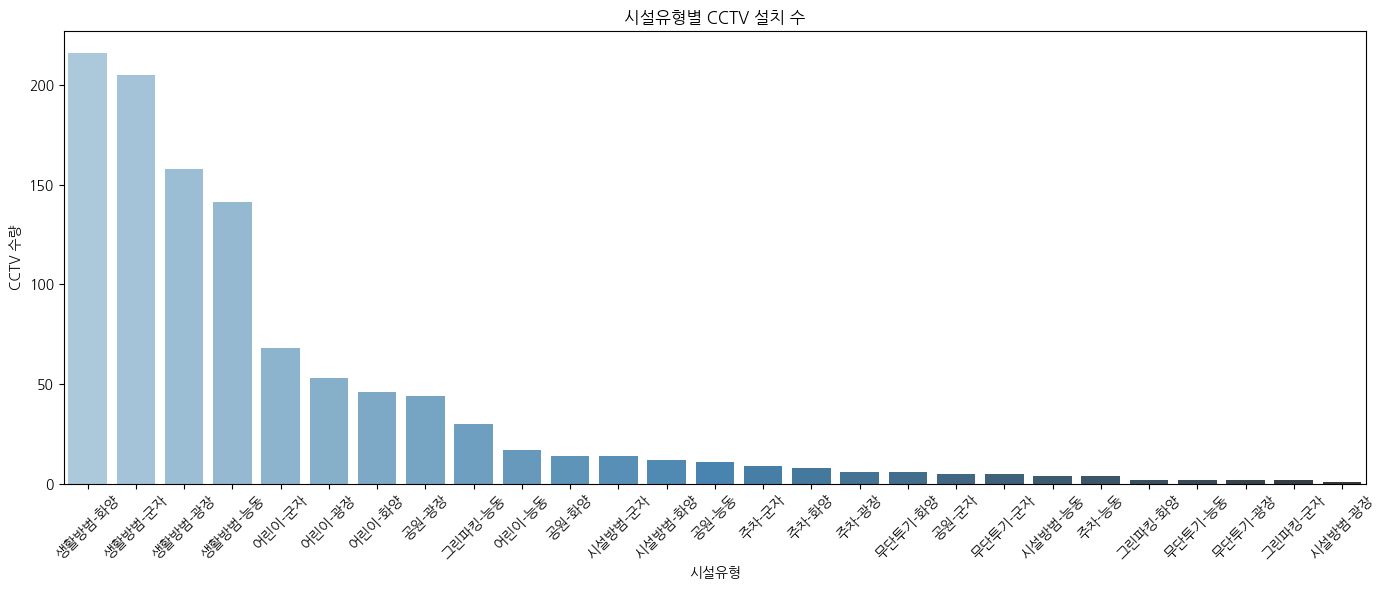

In [18]:
df_grouped_named = df.groupby('시설유형')['CCTV 수량'].sum().reset_index().sort_values(by='CCTV 수량', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(data=df_grouped_named, x='시설유형', y='CCTV 수량', hue='시설유형', palette='Blues_d',legend=False )
plt.xticks(rotation=45)
plt.title("시설유형별 CCTV 설치 수")
plt.tight_layout()

plt.savefig("../../results/cctv_by_facility_type.png", dpi=150)
plt.show()

In [9]:
unclustered = df[df['cluster'] == -1]
print("단독 설치 CCTV 개수:", len(unclustered))

단독 설치 CCTV 개수: 10


In [13]:
import folium

# 단독 설치 필터링 (cluster == -1)
unclustered = df[df['cluster'] == -1]

# '도로' 관련 시설유형 제외
unclustered_filtered = unclustered[~unclustered['시설유형'].str.contains("도로", na=False)]

# folium 지도 생성 (광진구 중심 좌표)
m = folium.Map(location=[37.545, 127.085], zoom_start=13)

# 필터링된 단독 CCTV만 표시
for _, row in unclustered_filtered.iterrows():
    lat, lon = row['위도'], row['경도']
    folium.CircleMarker(
        location=(lat, lon),
        radius=5,
        color='red',
        fill=True,
        fill_opacity=0.8,
        popup=f"{row['시설유형']} - 단독 설치"
    ).add_to(m)

# 바로 Jupyter에서 시각화
m


In [20]:
df['시설유형'] = df['안심 주소'].astype(str).str.extract(r'^([^-]+-[^-]+)')

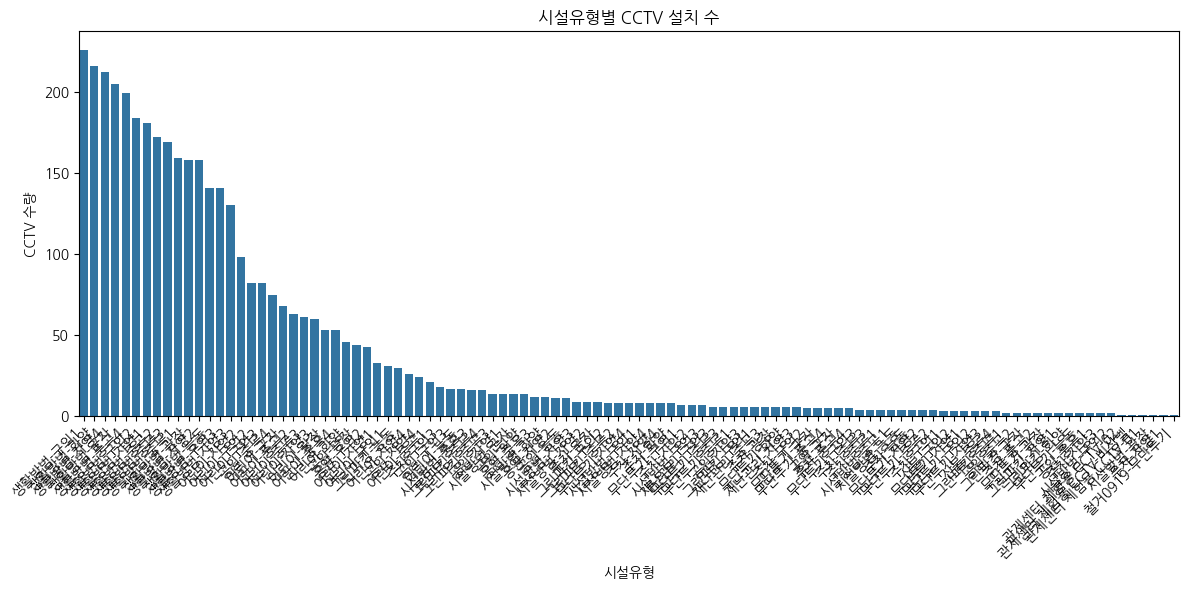

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (NanumGothic 등 시스템 내 사용 가능한 것으로)
plt.rcParams['font.family'] = 'NanumGothic'  # Linux 사용자 (설치되어 있다면)
plt.rcParams['axes.unicode_minus'] = False

# 그룹화: 시설유형별 CCTV 수량 총합
df_grouped = df.groupby('시설유형')['CCTV 수량'].sum().sort_values(ascending=False).reset_index()

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=df_grouped, x='시설유형', y='CCTV 수량')
plt.title("시설유형별 CCTV 설치 수")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("../../results/cctv_by.png", dpi=150)
plt.show()


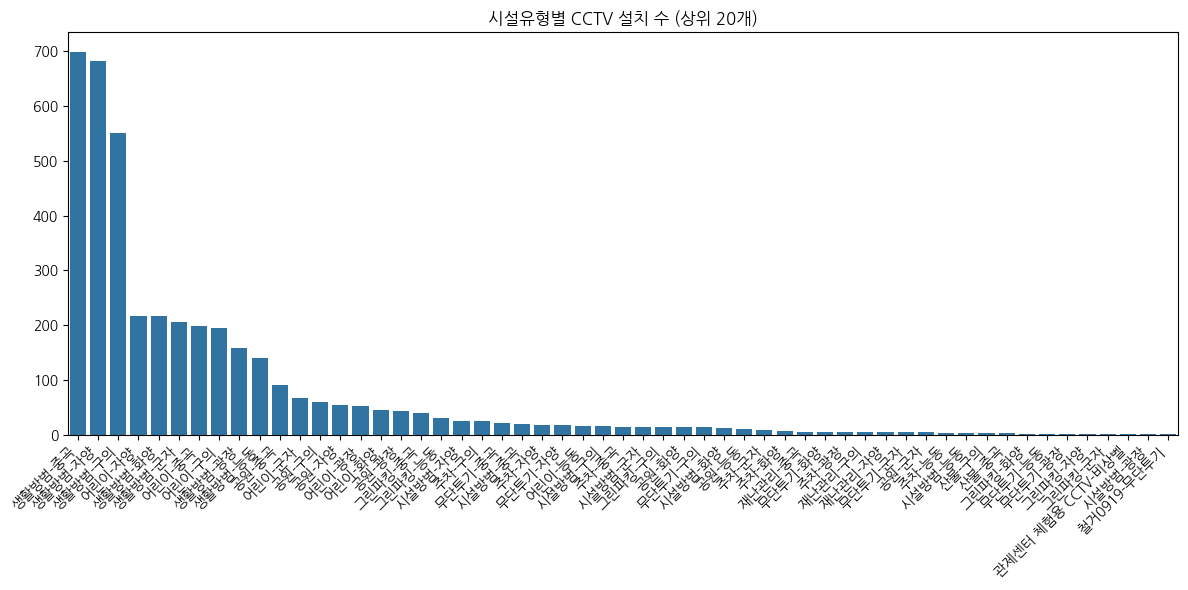

In [30]:
import os

# 1. 시설유형 전처리 (예: '생활방범-구의1' → '생활방범-구의')
df['시설유형'] = df['안심 주소'].astype(str).str.extract(r'^([^-]+-[가-힣]+)')

# 2. 그룹화: 시설유형별 CCTV 수량 집계
df_grouped = df.groupby('시설유형')['CCTV 수량'].sum().sort_values(ascending=False).reset_index()

# 3. 시각화: 숫자 없이 상위 시설유형만 막대 그래프
plt.rcParams['font.family'] = 'NanumGothic'   # Linux 사용자 (설치된 경우)
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6))
sns.barplot(data=df_grouped, x='시설유형', y='CCTV 수량')
plt.xticks(rotation=45, ha='right')
plt.title("시설유형별 CCTV 설치 수 (상위 20개)")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()

# 4. 저장 경로 설정 및 저장
output_dir = "../../results"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/cctv_by.png", dpi=150)

plt.show()

In [3]:
# 📘 1. 라이브러리 불러오기
import pandas as pd
import os

# 📁 2. 전처리된 CCTV 데이터 로드
df = pd.read_csv("../../data/processed_cctv.csv", encoding="cp949")

# ✅ 3. 시설유형 v1: 숫자 제거 ("공원-광장1" → "공원 광장")
df['시설유형_v1'] = df['안심 주소'].astype(str).str.extract(r'^([^-]+-[^-]+)')
df['시설유형_v1'] = df['시설유형_v1'].str.replace(r'\d+', '', regex=True).str.replace('-', ' ')

# ✅ 4. 시설유형 v2: 숫자 유지 ("공원-광장1" → "공원 광장1")
df['시설유형_v2'] = df['안심 주소'].astype(str).str.extract(r'^([^-]+-[^-]+)')
df['시설유형_v2'] = df['시설유형_v2'].str.replace('-', ' ')

# ✅ 5. 저장 디렉토리 생성
os.makedirs("../../results", exist_ok=True)

# 💾 6. CSV 저장
df.to_csv("../../results/processed_with_facility_v1_v2.csv", index=False, encoding="utf-8-sig")
print("✅ 저장 완료: processed_with_facility_v1_v2.csv")

# 선택적으로 v1/v2 각각만 따로 저장하고 싶다면 아래도 추가 가능
df[['안심 주소', '위도', '경도', 'CCTV 수량', '시설유형_v1']].to_csv(
    "../../results/facility_v1_only.csv", index=False, encoding="utf-8-sig"
)
df[['안심 주소', '위도', '경도', 'CCTV 수량', '시설유형_v2']].to_csv(
    "../../results/facility_v2_only.csv", index=False, encoding="utf-8-sig"
)
print("✅ 별도 저장 완료: facility_v1_only.csv, facility_v2_only.csv")


✅ 저장 완료: processed_with_facility_v1_v2.csv
✅ 별도 저장 완료: facility_v1_only.csv, facility_v2_only.csv
